<a href="https://colab.research.google.com/github/decorouz/CIFAR10-Object-Recognition/blob/main/Ag_land_use_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.   Title
2.   About
3.   The data:
      - Get the data
      - create dataset

4.   Create Model
5.   Create Mask of Land
6.   More





# Land Use Classification

## Background
Determining how land is used is a huge problem today. After all, its improper and illegal use can lead to both economic and natural disasters. One of the ways to assess the use is the analysis of aerial and satellite images of the earth's surface. A big problem is to build a mathematical model that can determine the type of land use based on colors. If you have ready-made photos and masks of land use, you can use the methods of artificial intelligence and big data to build a model-classifier.

## Import the required libraries for this project.

I will use libraries `os` and `glob` to work with files and folders. `Matplotlib` and `Seaborn` for visualizing our dataset to gain a better understanding of the images we are going to be handling. `NumPy` will be used for arrays of images. `Scikit-Learn` - for classical classification models. `Pandas` - for DataSet creation.



In [1]:
# install dependencies
!pip install colormap
!pip install easydev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for colormap: filename=colormap-1.0.4-py3-none-any.whl size=15638 sha256=e50a32ef4e464ace7d42e58881159e8c8934cf3bedd80e972a7702c0dfc48617
  Stored in directory: /root/.cache/pip/wheels/31/58/37/3b4e752e680f9eef40869ad6d3d6bb9932704207384f8259b0
Successfully built colormap
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 KB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=91191f83f41aec92a5638ac022d4c52b5d5c09f2a7b270261dd4bf3d5a558d65
  Stored in directory: /root/.cache/pip/wheels/e2/47/9f/de01f291cfde341b33383bcf1292b17d64c700d4a12b318a7d
Successfully built easydev


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import json

import os
from glob import glob

from colormap import rgb2hex, hex2rgb
from PIL import Image

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

## Setting up Kaggle environment

In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In order to use the Kaggle’s public API, you must first authenticate using an API token. From the [kaggle](https://www.kaggle.com/account) site header, click on your user profile picture, then on “My Account” from the dropdown menu. This will take you to your account settings. Scroll down to the section of the page labelled API:

To create a new token, click on the “Create New API Token” button. This will download a fresh authentication token onto your machine.

In [4]:
# configuring the path of Kaggle.json filem
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
# download the dataaset via API
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery --force

 84% 25.0M/29.6M [00:00<00:00, 47.6MB/s]
100% 29.6M/29.6M [00:00<00:00, 48.8MB/s]


In [6]:
import zipfile
source_zip ="/content/semantic-segmentation-of-aerial-imagery.zip"
zip_ref = zipfile.ZipFile(source_zip, 'r')
zip_ref.extractall()
zip_ref.close()

## The Data

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

1. Building: #3C1098
2. Land (unpaved area): #8429F6
3. Road: #6EC1E4
4. Vegetation: #FEDD3A
5. Water: #E2A929
6. Unlabeled: #9B9B9B




### Loading the dataset

Create a function `get_segmentation_data`. It does the following
1. Downloads a csv and display class description
2. Download specific images from specific directory
3. Display the last image and mask
4. Form and display a dataset that has to be an array of tuples `(image, mask)`


> **Remark**: the downloaded directories contain 72 images and their masks located in different subfolders according to image resolutions. Due to the fact that the dataset for training will represent each point in the form of a separate record - the size of the dataset will be too large to conduct the training on a local computer. Therefore, we will select a separate folder that contains 9 photos and their masks.



In [7]:

def get_segmentation_data(folder_name, filename):
  """
  Forms and returns a dataset of array of tuples
  
  Parameters:
  ----------
    folder_name: string
      name of a existing folder
    filename: string
      name of an existing file
  Returns
  --------
    data: array of tuples
  """
  #download the json file
  try:
    with open(folder_name + '/' + filename) as file:
      data = json.load(file)
  except FileNotFoundError:
    raise FileNotFoundError(f"Unrecognized file or folder name")

  # create a dictionary with the classes
  cl = {}
  for i,item in enumerate(data["classes"]):
    cl[i] = dict(item)
  
  for key, value in cl.items():
    print("Class", key)
    for k,v in value.items():
      print("  ", k,v)
      

  data = []
  #download the image files
  sub_directories = [item for item in os.listdir(folder_name) if os.path.isdir(folder_name + "/" + item)]

  # choice a directory to download files from
  for file in sub_directories[2:3]:
    print("\nDownloading ", file)
    images = glob(folder_name + "/" + file + "/images" + "/*.jpg")
    for im in images:
      mask_file = im.replace("images", "masks").replace("jpg", "png")
      image = Image.open(im)
      mask = Image.open(mask_file)
     
      if len(np.array(mask).shape) > 2: 
        data.append([image, mask])
     # display the last images + mask
    fig = plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()
  

  return (data)


Class 0
   title Water
   shape polygon
   color #50E3C2
   geometry_config {}
Class 1
   title Land (unpaved area)
   shape polygon
   color #F5A623
   geometry_config {}
Class 2
   title Road
   shape polygon
   color #DE597F
   geometry_config {}
Class 3
   title Building
   shape polygon
   color #D0021B
   geometry_config {}
Class 4
   title Vegetation
   shape polygon
   color #417505
   geometry_config {}
Class 5
   title Unlabeled
   shape polygon
   color #9B9B9B
   geometry_config {}



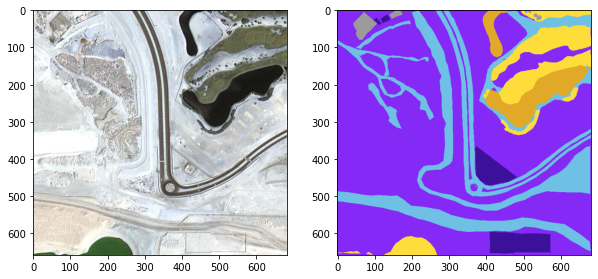

In [8]:

folder_name = "Semantic segmentation dataset"
filename = "classes.json"
data =get_segmentation_data(folder_name, filename)


Upon observation, we can see the csv file contains a description of 6 land use classes. Each class has its own color in the mask file. We downloaded all the pictures and their masks from a separate directory and formed a set of data lists consisting of tuples of picture-mask.

### Create the Dataset

In [9]:

# Explore an example of the downloaded data

print("The shape of the first image",np.array(data[0][0]).shape) # the shape of the image
print("The shape of the first mask", np.array(data[0][1]).shape) # the shape of the mask
print("The number of downloaded images ", len(data))

np.asarray(data[:1][0][0])[:,:,0].flatten()
np.asarray(data[:1][0][0])[:,:,1].flatten()
np.asarray(data[:1][0][0])[:,:,2].flatten()
np.asarray(data[:1][0][0])[:,:,2].shape

# np.array([np.asarray(data[:1][0][0])[:,:,0].flatten(), np.asarray(data[0][0])[:,:,1].flatten(), np.asarray(data[0][0])[:,:,2].flatten()]).shape


The shape of the first image (658, 682, 3)
The shape of the first mask (658, 682, 3)
The number of downloaded images  9


(658, 682)

We downloaded 9 images. Lets use 3 images and mask for training the other 5  for test.

Let's make a function that will create a DataSet.

Each image is a set of points. Each point is represented by a tuple of RGB (red, green, blue). Every color is a number [0-1) for float or [0, 255) for int. Therefore, every image is a 3D array (height, width, color). Or a 2D array for gray scale.

To establish the dependence of color -> land use class, we need to convert each image into a dataset of the form (r, g, b) -> class.

To do this, we need to transform the image into a color matrix `np.asarray()`, and then transform it into a one-dimensional form `np.flatten()`. To construct the output field, we need to additionally convert the color tuple (r, g, b) from the mask file into hex format: `rgb2hex()`.

In [10]:
def create_dataset(data):
  DS = pd.DataFrame()

  #transform image to numpy array
  for image, mask in data:
    im = np.asarray(image)
    mk = np.asarray(mask)

    #transform to one-dimensional
    red = im[:,:,0].flatten()
    blue = im[:,:,1].flatten()
    green = im[:,:,2].flatten()
    im_f = np.array([red, blue, green])

    red = mk[:,:,0].flatten()
    blue = mk[:,:,1].flatten()
    green = mk[:,:,2].flatten()
    # calculate the hex class
    h = np.array([rgb2hex(*m) for m in zip(red, blue, green)])
    mk_f = np.array([red, blue, green, h])

    d = np.concatenate((im_f, mk_f), axis=0)
    #create the dataset
    DS_new = pd.DataFrame(np.transpose(d), columns = ['Im_Red', 'Im_Green', 'Im_Blue', 'Mk_Red', 'Mk_Green', 'Mk_Blue', 'HEX'])
    if len(DS) == 0:
      DS = DS_new
    else:
      DS = DS.append(DS_new)

  return DS






In [11]:
print("Creating train Dateset")
train_set = create_dataset(data[:4])
print(train_set)
print("Creating test Dateset")
test_set = create_dataset(data[4:])
print(test_set)

Creating train Dateset
       Im_Red Im_Green Im_Blue Mk_Red Mk_Green Mk_Blue      HEX
0          14       14      14    226      169      41  #E2A929
1          13       13      13    226      169      41  #E2A929
2          13       13      13    226      169      41  #E2A929
3          13       13      13    226      169      41  #E2A929
4           8        8       8    226      169      41  #E2A929
...       ...      ...     ...    ...      ...     ...      ...
448751     10        9       7    226      169      41  #E2A929
448752     11       11       9    226      169      41  #E2A929
448753     17       17      15    226      169      41  #E2A929
448754     21       21      19    226      169      41  #E2A929
448755     20       20      18    226      169      41  #E2A929

[1795024 rows x 7 columns]
Creating test Dateset
       Im_Red Im_Green Im_Blue Mk_Red Mk_Green Mk_Blue      HEX
0         157      147     146     60       16     152  #3C1098
1         173      163     162 

Lets examine the column types of the train and test set

In [12]:
train_set.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1795024 entries, 0 to 448755
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Im_Red    object
 1   Im_Green  object
 2   Im_Blue   object
 3   Mk_Red    object
 4   Mk_Green  object
 5   Mk_Blue   object
 6   HEX       object
dtypes: object(7)
memory usage: 109.6+ MB


In [13]:
test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243780 entries, 0 to 448755
Data columns (total 7 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   Im_Red    object
 1   Im_Green  object
 2   Im_Blue   object
 3   Mk_Red    object
 4   Mk_Green  object
 5   Mk_Blue   object
 6   HEX       object
dtypes: object(7)
memory usage: 136.9+ MB


The `HEX` column contains colors in hex format. Change to categorical variable.


In [14]:
train_set.loc[:, "HEX"] = train_set["HEX"].astype("category")
train_set["HEX"]

0         #E2A929
1         #E2A929
2         #E2A929
3         #E2A929
4         #E2A929
           ...   
448751    #E2A929
448752    #E2A929
448753    #E2A929
448754    #E2A929
448755    #E2A929
Name: HEX, Length: 1795024, dtype: category
Categories (7, object): ['#000000', '#3C1098', '#6EC1E4', '#8429F6', '#9B9B9B', '#E2A929', '#FEDD3A']

In [15]:
test_set.loc[:, "HEX"] = test_set["HEX"].astype("category")
test_set["HEX"]

0         #3C1098
1         #3C1098
2         #3C1098
3         #3C1098
4         #3C1098
           ...   
448751    #8429F6
448752    #8429F6
448753    #8429F6
448754    #8429F6
448755    #8429F6
Name: HEX, Length: 2243780, dtype: category
Categories (7, object): ['#000000', '#3C1098', '#6EC1E4', '#8429F6', '#9B9B9B', '#E2A929', '#FEDD3A']

All other columns are in integer format. Therefore they should be casted as int




In [16]:
columns = ["Im_Red", "Im_Green", "Im_Blue", "Mk_Red", "Mk_Green", "Mk_Blue"]
train_set[columns] = train_set[columns].astype("int64")
test_set[columns] = test_set[columns].astype("int64")

print(test_set.info())
print(train_set.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2243780 entries, 0 to 448755
Data columns (total 7 columns):
 #   Column    Dtype   
---  ------    -----   
 0   Im_Red    int64   
 1   Im_Green  int64   
 2   Im_Blue   int64   
 3   Mk_Red    int64   
 4   Mk_Green  int64   
 5   Mk_Blue   int64   
 6   HEX       category
dtypes: category(1), int64(6)
memory usage: 122.0 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1795024 entries, 0 to 448755
Data columns (total 7 columns):
 #   Column    Dtype   
---  ------    -----   
 0   Im_Red    int64   
 1   Im_Green  int64   
 2   Im_Blue   int64   
 3   Mk_Red    int64   
 4   Mk_Green  int64   
 5   Mk_Blue   int64   
 6   HEX       category
dtypes: category(1), int64(6)
memory usage: 97.6 MB
None


Let visualize our data and lets see exactly what we have. 


In [17]:
import seaborn as sns
sns.set_theme(style="darkgrid")


In [18]:
# # remove category value "#000000" from "HEX" column
# train_set["HEX"] = train_set["HEX"].cat.remove_categories("#000000")
# test_set["HEX"] = test_set["HEX"].cat.remove_categories("#000000")


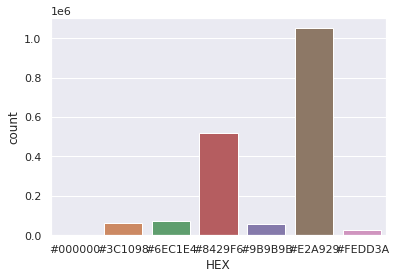

In [19]:
c = pd.DataFrame(train_set["HEX"])
sns.countplot(x="HEX", data=c)
plt.show()

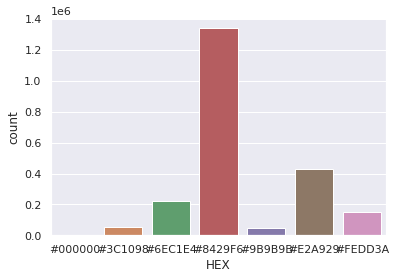

In [20]:
t = pd.DataFrame(test_set["HEX"])
sns.countplot(x="HEX", data=t)
plt.show()

The training data now contains 6 land use classes after removing the class '#000000' that doesn't seem to affect the data with count zero.

## Classification Model Creation

I will first use `sklearn.linear_model.LogisticRegression()` classifier for mask analysis.

> **I will explore other models subsequently**

Use the first 3 columns (RGB of image pixel) as imput parameters, and the last column (HEX color of mask picture) as an output.

The fit() and score() functions are used for training and evaluating the accuracy.

`plot_confusion_matrix()` for analysis.

In [21]:

clf = LogisticRegression(max_iter=100, n_jobs=-1)
c = train_set.columns
X_train = train_set[c[0:3]]
y_train = train_set[c[-1:]].values.ravel()

clf.fit(X_train, y_train)


LogisticRegression(n_jobs=-1)

Accuracy train_set DataSet:  86.5% Accuracy test_set DataSet:  86.5%


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


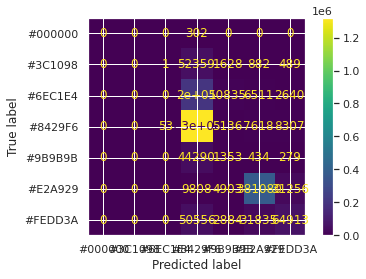

In [22]:
X_test = test_set[c[0:3]]
y_test = test_set[c[-1:]].values.ravel()

scores_train = clf.score(X_train, y_train)
scores_test = clf.score(X_test, y_test)
print('Accuracy train_set DataSet: {: .1%}'.format(scores_train), 'Accuracy test_set DataSet: {: .1%}'.format(scores_train))
plot_confusion_matrix(clf, test_set[c[0:3]], test_set[c[-1:]].values.ravel())  
plt.show()